In [119]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("XLSX")
Pkg.add("CSV")
Pkg.add("Distributions")


  Activating project at `~/Desktop/BEE 4750/BEE4750FinalProject-1`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`


In [120]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
using XLSX
using CSV
using Distributions

Load Data for all buildings

In [121]:
# Read the CSV file into a DataFrame
df = CSV.read("CascadillaHall.csv", DataFrame)
date = df."Date"[1:366]
casc_steam = df."Steam (lbs/hr)"[1:366]
casc_electric = df."Electric (kW)"[1:366]
casc_data = Dict("steam" => casc_steam, "electric" => casc_electric)

df = CSV.read("HuShihHall.csv", DataFrame)
hushih_chilled_water = df."Chilled Water (tons)"[1:366]
hushih_hot_water = df."Hot Water (kBTU/hr)"[1:366]
hushih_electric = df."Electric (kW)"[1:366]
hushih_data = Dict("chilled water" => hushih_chilled_water, "hot water" => hushih_hot_water, "electric" => hushih_electric)

df = CSV.read("UrisLibrary.csv", DataFrame)
uris_chilled_water = df."Chilled Water (tons)"[1:366]
uris_electric = df."Electric (kW)"[1:366]
uris_steam = df."Steam (lbs/hr)"[1:366]
uris_data = Dict("steam" => uris_steam, "electric" => uris_electric, "chilled water" => uris_chilled_water)

df = CSV.read("MannLibrary.csv", DataFrame)
mann_chilled_water = df."Chilled Water (tons)"[1:366]
mann_electric = df."Electric (kW)"[1:366]
mann_steam = df."Steam (lbs/hr)"[1:366]
mann_data = Dict("steam" => mann_steam, "electric" => mann_electric, "chilled water" => mann_chilled_water)

df = CSV.read("BakerLab.csv", DataFrame)
baker_chilled_water = df."Chilled Water (tons)"[1:366]
baker_electric = df."Electric (kW)"[1:366]
baker_steam = df."Steam (lbs/hr)"[1:366]
baker_data = Dict("steam" => baker_steam, "electric" => baker_electric, "chilled water" => baker_chilled_water)


df = CSV.read("PSB.csv", DataFrame)
psb_chilled_water = df."Chilled Water (tons)"[1:366]
psb_electric = df."Electric (kW)"[1:366]
psb_steam = df."Steam (lbs/hr)"[1:366]
psb_data = Dict("steam" => psb_steam, "electric" => psb_electric, "chilled water" => psb_chilled_water)


Dict{String, Vector{Union{Missing, Float64}}} with 3 entries:
  "electric"      => [548.81, 563.161, 572.473, 565.196, 542.293, 544.875, 557.…
  "steam"         => [2079.73, 1909.23, 2041.34, 2451.04, 2452.6, 2104.94, 2016…
  "chilled water" => [64.7096, 66.233, 69.2405, 68.8494, 72.2633, 71.9422, 72.2…

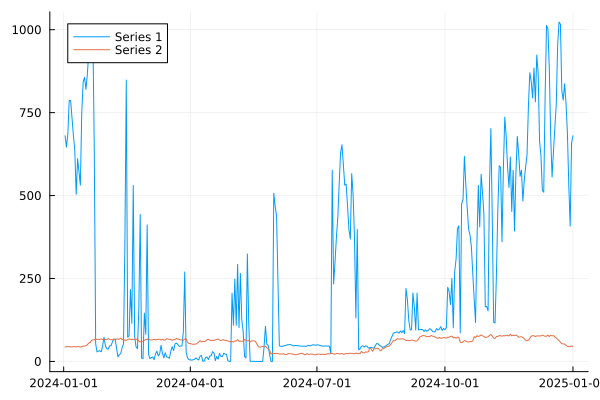

In [122]:
# Cascadilla plots
p = plot(date, casc_steam, label="Series 1")
plot!(p, date, casc_electric, label="Series 2")
display(p)

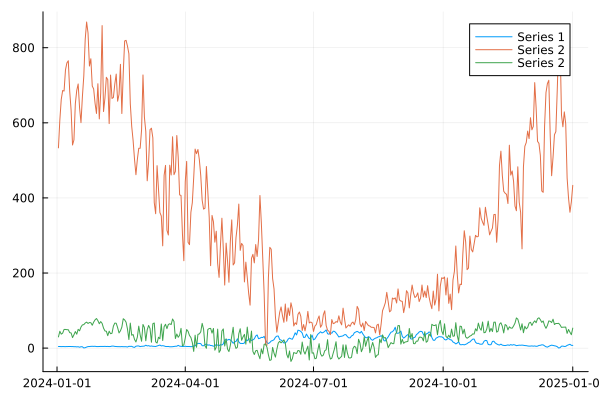

In [123]:
# Hu Shih Plots
p = plot(date, hushih_chilled_water, label="Series 1")
plot!(p, date, hushih_hot_water, label="Series 2")
plot!(p, date, hushih_electric, label="Series 2")
display(p)

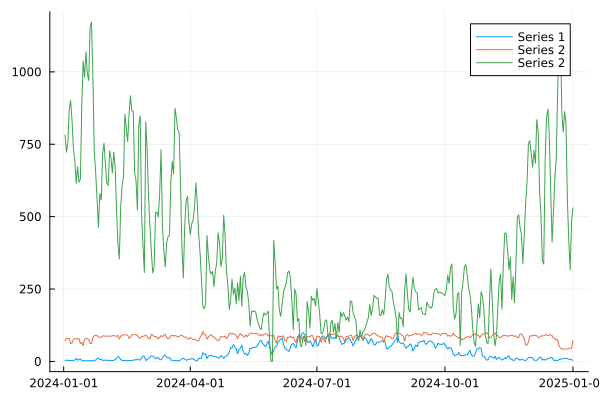

In [124]:
# Uris Library Plots
p = plot(date, uris_chilled_water, label="Series 1")
plot!(p, date, uris_electric, label="Series 2")
plot!(p, date, uris_steam, label="Series 2")
display(p)

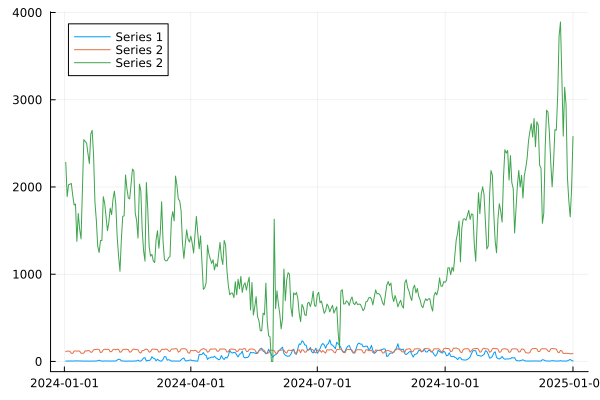

In [125]:
# Mann Library Plots
p = plot(date, mann_chilled_water, label="Series 1")
plot!(p, date, mann_electric, label="Series 2")
plot!(p, date, mann_steam, label="Series 2")
display(p)

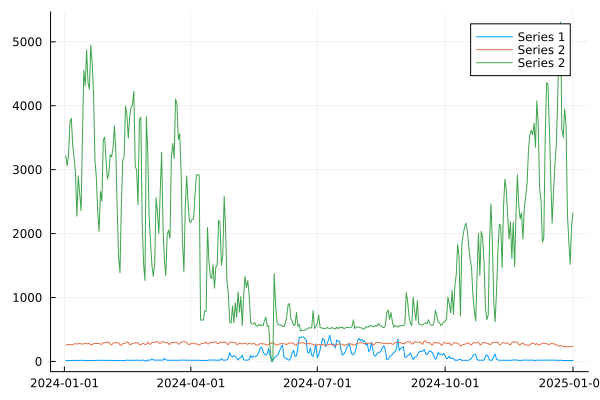

In [126]:
# Baker Lab Plots
p = plot(date, baker_chilled_water, label="Series 1")
plot!(p, date, baker_electric, label="Series 2")
plot!(p, date, baker_steam, label="Series 2")
display(p)

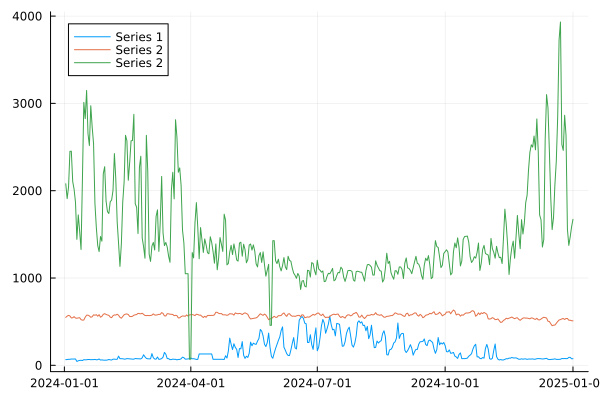

In [127]:
# PSB Plots
p = plot(date, psb_chilled_water, label="Series 1")
plot!(p, date, psb_electric, label="Series 2")
plot!(p, date, psb_steam, label="Series 2")
display(p)

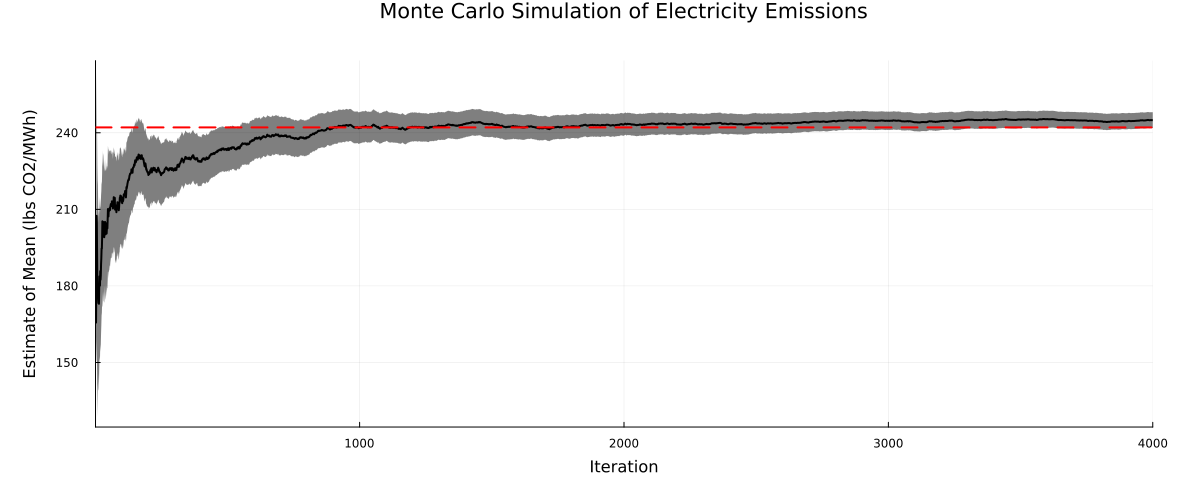

In [146]:
# ---------------------------------------------------------
#  Function: draw one sample from Normal(242.1, 30)
# ---------------------------------------------------------
function normal_sample_repeated(n_trials)
    dist = Normal(242.1, 100)
    samples = rand(dist, n_trials)
    return samples
end

# ---------------------------------------------------------
# Monte Carlo simulation parameters
# ---------------------------------------------------------
nsamp = 4000
samples = normal_sample_repeated(nsamp)

# ---------------------------------------------------------
# Storage for running mean estimate and standard error
# ---------------------------------------------------------
running_mean = zeros(nsamp)
running_se = zeros(nsamp)

running_mean[1] = samples[1]
running_se[1] = 0   # no SE for one point

for i in 2:nsamp
    # running mean
    running_mean[i] = mean(samples[1:i])

    # standard error of the mean
    running_se[i] = std(samples[1:i]) / sqrt(i)
end

# ---------------------------------------------------------
# PLOT
# ---------------------------------------------------------
plt = plot(
    running_mean,
    ribbon = 1.96 .* running_se,
    xlim = (1, nsamp),
    legend = false,
    xlabel = "Iteration",
    ylabel = "Estimate of Mean (lbs CO2/MWh)",
    color = :black,
    linewidth = 2,
    size = (1200, 500),
    title = "Monte Carlo Simulation of Electricity Emissions",
    left_margin = 10mm,
    bottom_margin = 10mm,
    top_margin = 10mm,
    right_margin = 10mm
)
hline!(plt, [242.1], color = "red", linestyle = :dash, linewidth = 2)

plt


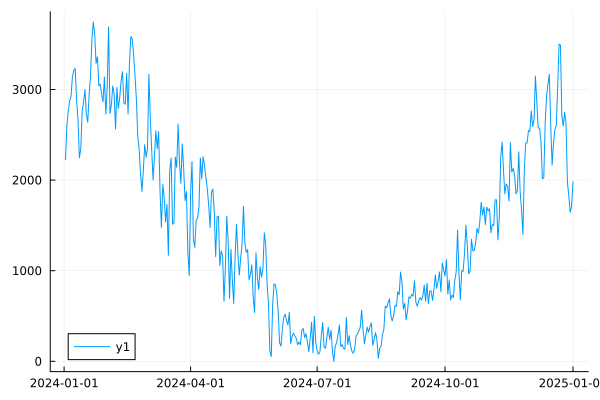

In [79]:
function calc_emissions(data_dict)
    emissions = zeros(366)
    for (key, values_vector) in data_dict
        if key == "steam"
            # Assumptions (based on CEP fast facts and 2020 report)
            # Plant efficiency: 76%
            # Energy losses in pipes: 27%
            # 795,000klbs = 819,000 mmBTU
            # 1 cubic foot of natural gas ≈ 1,037 Btu
            # 0.12 lbs CO2 / 1 cubic foot of natural gas
            for i in 1:366
                # convert lbs/hr to 819,000 mmBTU/hr
                mmBTU_hr = data_dict["steam"][i] * 819000/(795000*1000)
                # convert mmBTU at delivered to mmBTU of nat gas
                mmBTU_hr = mmBTU_hr / (1-0.27) / 0.76
                # convert mmBTU of nat gas to cubic ft natural gas
                cfs = mmBTU_hr * 1000000 / 1037
                # convert cubic ft natural gas to lbs CO2
                co2 = cfs * 0.12
                # hrs to day
                emissions[i] += co2*24
            end
        elseif key == "electric"
            # Source is egrid from the EPA
            for i in 1:366
                # convert kW reading into MWh for a day
                MWh = data_dict["electric"][i] * 24 / 1000
                # convert MWh to emissions (lbs CO2)
                emissions[i] += 242.1 * MWh
            end
            
        elseif key == "chilled water"
            # Assume lake source cooling, uses 0.1-0.15 kW/ton
            for i in 1:366
                # convert tons to kW
                kW = data_dict["chilled water"][i] * 0.125
                # convert kW reading into MWh for a day
                MWh = kW * 24 / 1000
                # convert MWh to emissions (lbs CO2)
                emissions[i] += 242.1 * MWh
            end
        elseif key == "hot water"
            # Changed assumption: energy losses in pipes: 5%
            for i in 1:366
                # convert kBTU/hr delivered to kBTU/hr of natural gas 
                kbtu_hr = data_dict["hot water"][i] / (1-0.05) / 0.76
                # convert kBTU of nat gas to cubic ft natural gas
                cfs = kbtu_hr * 1000 / 1037
                # convert cubic ft natural gas to lbs CO2
                co2 = cfs * 0.12
                # hrs to day
                emissions[i] += co2*24
            end
        else
            println("Unknown key found: $key")
        end
    end

    return emissions
end


e = calc_emissions(hushih_data)
plot(date, e)



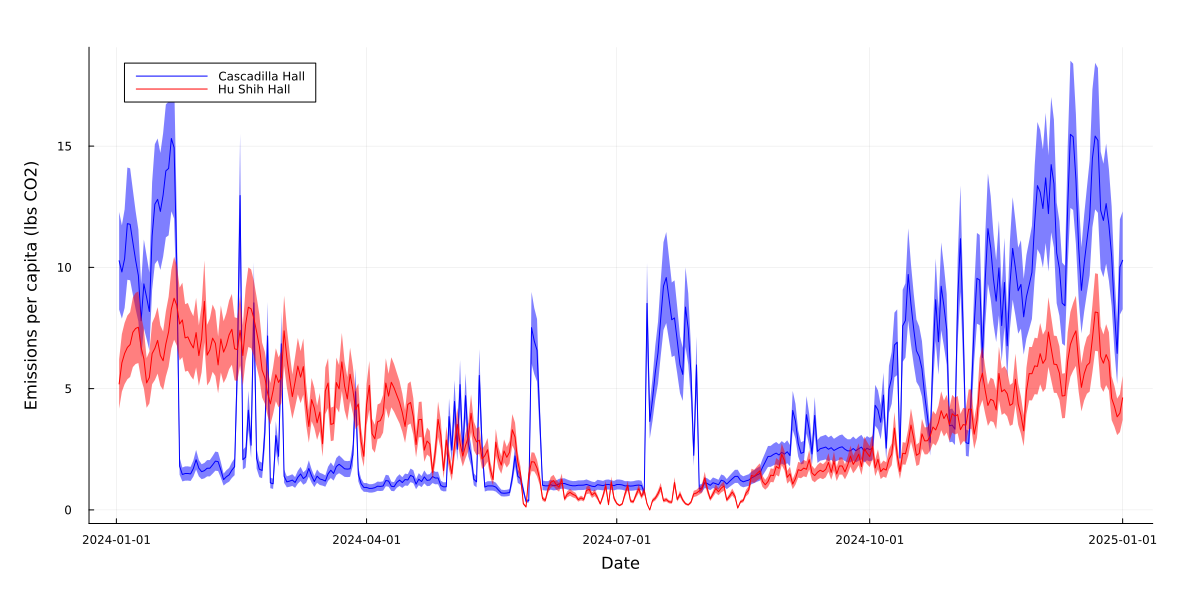

In [153]:
casc_emissions = calc_emissions(casc_data)
hushih_emissions = calc_emissions(hushih_data)

# adjust by number of residents
for i in 1:366
    casc_emissions[i] = casc_emissions[i] / 366
    hushih_emissions[i] = hushih_emissions[i] / 429
end

# Example: assume standard deviation per day = 10% of the per-capita emissions
# You can replace this with your actual uncertainty calculation
casc_std = 0.10 .* casc_emissions
hushih_std = 0.10 .* hushih_emissions

# 95% confidence interval = 1.96 * std
casc_ribbon = 1.96 .* casc_std
hushih_ribbon = 1.96 .* hushih_std

# Plot
p = plot(
    date,
    casc_emissions,
    ribbon = casc_ribbon,
    label = "Cascadilla Hall",
    xlabel = "Date",
    ylabel = "Emissions per capita (lbs CO2)",
    #title = "Emissions per Capita vs Time",
    size = (1200, 600),
    color = :blue,
    left_margin = 10mm,
    bottom_margin = 10mm,
    top_margin = 10mm,
    right_margin = 10mm
)

plot!(
    p,
    date,
    hushih_emissions,
    ribbon = hushih_ribbon,
    label = "Hu Shih Hall",
    color = :red
)

display(p)


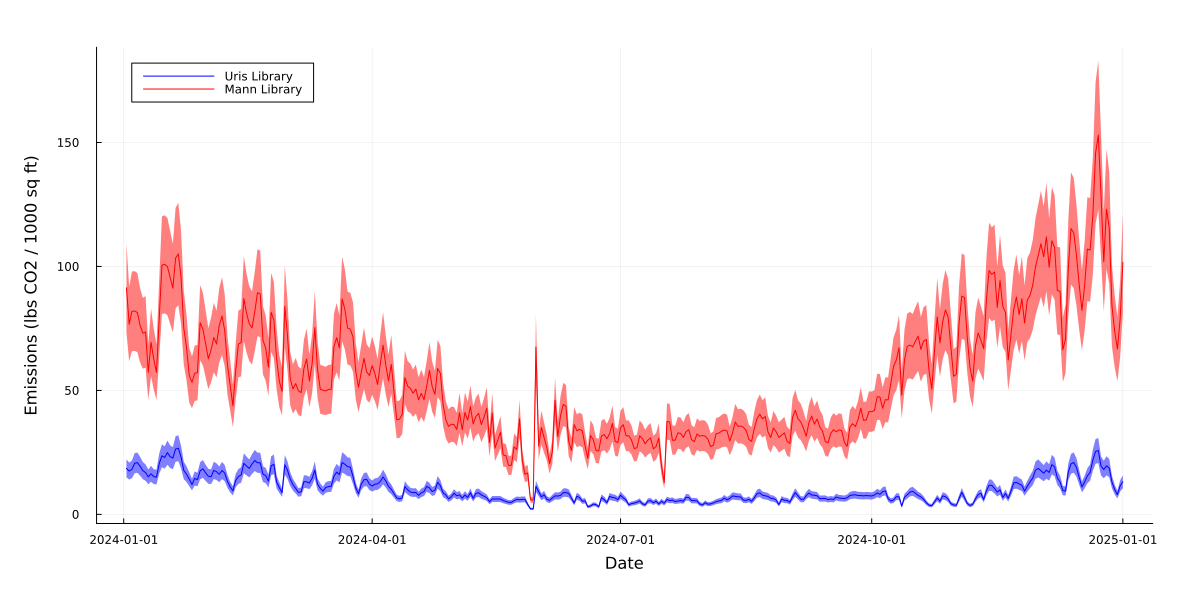

In [161]:
uris_emissions = calc_emissions(uris_data)
mann_emissions = calc_emissions(mann_data)

# adjust by square feet
for i in 1:366
    uris_emissions[i] = uris_emissions[i] / 240
    mann_emissions[i] = mann_emissions[i] / 136
end

# Example: assume standard deviation per day = 10% of the per-capita emissions
# You can replace this with your actual uncertainty calculation
uris_std = 0.10 .* uris_emissions
mann_std = 0.10 .* mann_emissions

# 95% confidence interval = 1.96 * std
uris_ribbon = 1.96 .* uris_std
mann_ribbon = 1.96 .* mann_std

# Plot
p = plot(
    date,
    uris_emissions,
    ribbon = uris_ribbon,
    label = "Uris Library",
    xlabel = "Date",
    ylabel = "Emissions (lbs CO2 / 1000 sq ft)",
    #title = "Emissions per Capita vs Time",
    size = (1200, 600),
    color = :blue,
    left_margin = 10mm,
    bottom_margin = 10mm,
    top_margin = 10mm,
    right_margin = 10mm
)

plot!(
    p,
    date,
    mann_emissions,
    ribbon = mann_ribbon,
    label = "Mann Library",
    color = :red
)

display(p)


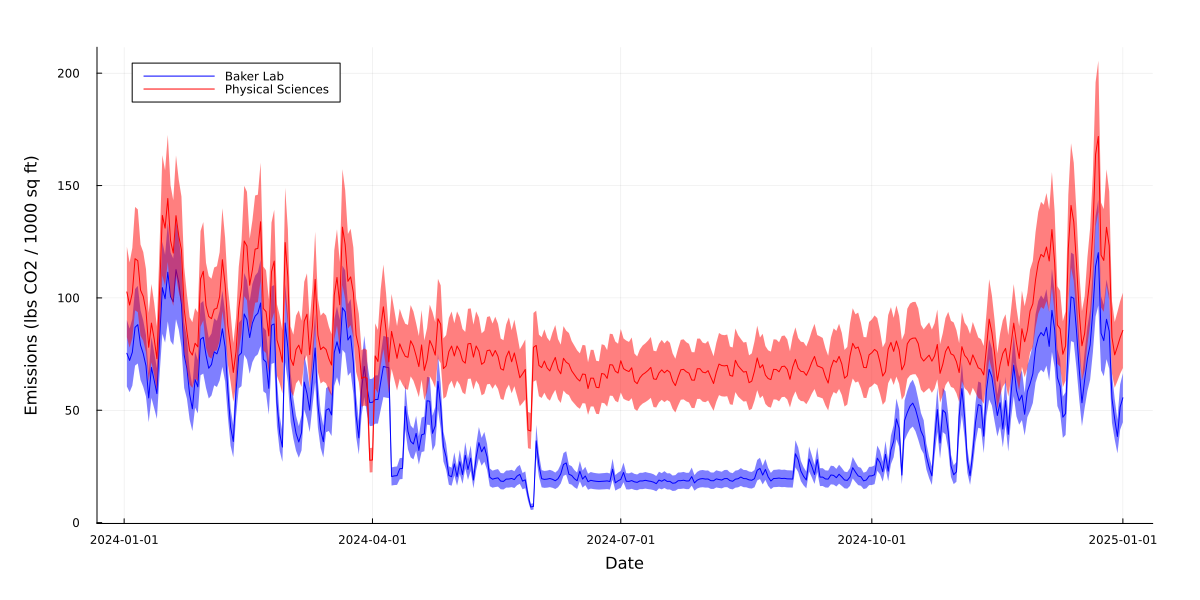

In [162]:
baker_emissions = calc_emissions(baker_data)
psb_emissions = calc_emissions(psb_data)

# adjust by square feet
for i in 1:366
    baker_emissions[i] = baker_emissions[i] / 240
    psb_emissions[i] = psb_emissions[i] / 136
end

# Example: assume standard deviation per day = 10% of the per-capita emissions
# You can replace this with your actual uncertainty calculation
baker_std = 0.10 .* baker_emissions
psb_std = 0.10 .* psb_emissions

# 95% confidence interval = 1.96 * std
baker_ribbon = 1.96 .* baker_std
psb_ribbon = 1.96 .* psb_std

# Plot
p = plot(
    date,
    baker_emissions,
    ribbon = baker_ribbon,
    label = "Baker Lab",
    xlabel = "Date",
    ylabel = "Emissions (lbs CO2 / 1000 sq ft)",
    #title = "Emissions per Capita vs Time",
    size = (1200, 600),
    color = :blue,
    left_margin = 10mm,
    bottom_margin = 10mm,
    top_margin = 10mm,
    right_margin = 10mm
)

plot!(
    p,
    date,
    psb_emissions,
    ribbon = psb_ribbon,
    label = "Physical Sciences",
    color = :red
)

display(p)
